In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Embedding,
    Conv1D,
    MaxPooling1D,
    Bidirectional,
    LSTM,
    Dense,
    Dropout,
    Input,
    Flatten,
    GlobalMaxPooling1D,
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# For evaluation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight



In [29]:
# Get all CSV files in the directory
file_path = '../data_pre/input_data'  # Update with your directory
all_files = glob.glob(os.path.join(file_path, '*.csv'))

# Initialize an empty list to hold DataFrames
df_list = []

# Loop over all files and read them
for filename in all_files:
    # Extract hotel name from filename
    hotel_name = os.path.basename(filename).replace('_input_data.csv', '')  # Removes directory and specific file extension
    temp_df = pd.read_csv(filename)
    temp_df['hotel'] = hotel_name  # Add a column for hotel name
    df_list.append(temp_df)

# Concatenate all DataFrames into one
df = pd.concat(df_list, ignore_index=True)



Review Provider     3081
Review ID              0
Review Content         0
Review Score           0
Review Time            0
normalized_score       0
Hotel                  0
cleaned_content        0
label                  0
hotel                  0
dtype: int64


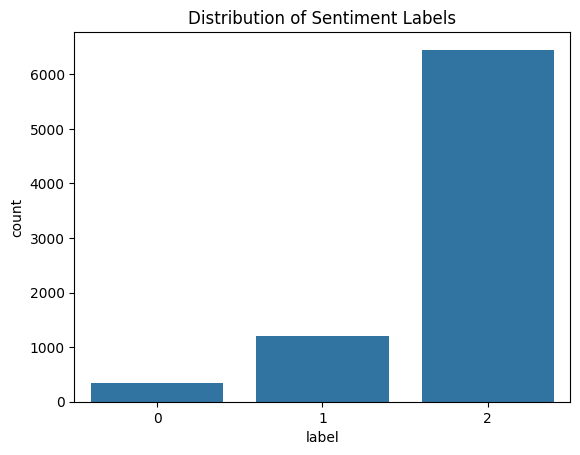

In [30]:
# Check for missing values
print(df.isnull().sum())

# Distribution of labels
sns.countplot(x='label', data=df)
plt.title('Distribution of Sentiment Labels')
plt.show()



In [31]:
from sklearn.model_selection import train_test_split

data = df

# Features and labels
X = data[['cleaned_content']]
y = data['label']

# Perform the split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=69)

# Reset index after splitting
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Display the distribution of labels in training and testing sets
print("Training label distribution:\n", y_train.value_counts())
print("\nTesting label distribution:\n", y_test.value_counts())


Training label distribution:
 label
2    4516
1     845
0     244
Name: count, dtype: int64

Testing label distribution:
 label
2    1936
1     363
0     104
Name: count, dtype: int64


In [32]:
from keras.preprocessing.sequence import pad_sequences

# Combine training and testing texts for fitting the tokenizer
texts = pd.concat([X_train['cleaned_content'], X_test['cleaned_content']])

# Initialize the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

# Convert texts to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train['cleaned_content'])
X_test_sequences = tokenizer.texts_to_sequences(X_test['cleaned_content'])

# Pad sequences to the same length
max_sequence_length = max([len(seq) for seq in X_train_sequences + X_test_sequences])
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post')


# Split X_test into validation and test sets
X_val, X_test_final, y_val, y_test_final = train_test_split(
    X_test_padded, y_test, test_size=0.5, stratify=y_test, random_state=69)


# Reset index after splitting
X_val = np.array(X_val)
X_test_final = np.array(X_test_final)
y_val = y_val.reset_index(drop=True)
y_test_final = y_test_final.reset_index(drop=True)

# Display the distribution of labels in validation and final test sets
print("Validation label distribution:\n", y_val.value_counts())
print("\nFinal Test label distribution:\n", y_test_final.value_counts())


Validation label distribution:
 label
2    968
1    181
0     52
Name: count, dtype: int64

Final Test label distribution:
 label
2    968
1    182
0     52
Name: count, dtype: int64


In [33]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# Prepare sentences for Word2Vec
sentences = [text.split() for text in texts]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences, vector_size=128, window=5, min_count=1, workers=4)

# Get the vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Create embedding matrix
embedding_dim = 128
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_vector = word2vec_model.wv[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


In [34]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

# Define model architecture
model = Sequential()

# Embedding layer with pre-trained weights
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    trainable=True))
# model.add(Dropout(0.1)) 
# Convolutional layer
model.add(Conv1D(filters=128, 
                 kernel_size=5, 
                #  kernel_regularizer=regularizers.l2(0.01),
                 bias_regularizer=regularizers.l2(0.1),
                 ))
model.add(BatchNormalization())  # Add BatchNormalization after Conv1D
model.add(Activation('relu'))     # Activation after BatchNorm
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3)) 

# Bidirectional LSTM layer
model.add(Bidirectional(LSTM(128, 
                             return_sequences=False,
                            #  kernel_regularizer=regularizers.l2(0.01),
                             bias_regularizer=regularizers.l2(0.1),
                             )))  
model.add(Dropout(0.3))

# Output layer
model.add(Dense(3, 
                activation='softmax',
                # kernel_regularizer=regularizers.l2(0.01),
                bias_regularizer=regularizers.l2(0.1),
                ))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])


In [35]:
# Hyperparameters
batch_size = 128
epochs = 15

In [36]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping



reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=2, 
    min_lr=1e-6
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Increase patience to allow for more epochs
    restore_best_weights=True
)

weights = class_weight.compute_class_weight(    
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train, 
    
)
class_weight_dict = dict(enumerate(weights))
print(class_weight_dict)

{0: 7.657103825136612, 1: 2.2110453648915187, 2: 0.413714201358134}


In [37]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



Num GPUs Available:  1


In [38]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=69)

# Apply SMOTE to the training data
X_train_padded, y_train = smote.fit_resample(X_train_padded, y_train)

# Display the distribution of labels after applying SMote
print("Training label distribution after SMOTE:\n", pd.Series(y_train).value_counts())

Training label distribution after SMOTE:
 label
2    4516
1    4516
0    4516
Name: count, dtype: int64


In [39]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Only show ERROR logs

# Train the model
history = model.fit(X_train_padded, y_train,
                    validation_data=(X_val, y_val),
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[
                        # reduce_lr,
                        early_stopping
                        ],
                    # class_weight=class_weight_dict,
                    )

Epoch 1/15


2024-09-28 18:05:49.447296: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1727517950.048571   36962 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727517950.234360   36962 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727517950.515274   36962 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727517950.563448   36962 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727517950.611532   36962 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727517950.643494   36962 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727517950.773623   36962 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727517950.814513   36962 gpu_t

105/106 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.5195 - loss: 3.3775

W0000 00:00:1727517975.504395   36961 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727517975.519001   36961 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727517975.524867   36961 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727517975.536726   36961 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727517975.545925   36961 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727517975.551620   36961 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727517975.557801   36961 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727517975.564786   36961 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727517975.571753   36961 gp

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.5199 - loss: 3.3756

W0000 00:00:1727517975.779942   36960 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727517975.788857   36960 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727517975.797727   36960 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727517975.802729   36960 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727517975.814159   36960 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727517975.821471   36960 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727517975.834238   36960 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727517975.854480   36960 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727517975.861644   36960 gp

106/106 ━━━━━━━━━━━━━━━━━━━━ 45s 192ms/step - accuracy: 0.5204 - loss: 3.3738 - val_accuracy: 0.6128 - val_loss: 2.9407
Epoch 2/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 19s 179ms/step - accuracy: 0.6314 - loss: 2.7050 - val_accuracy: 0.7027 - val_loss: 2.3963
Epoch 3/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 18s 167ms/step - accuracy: 0.6694 - loss: 2.2172 - val_accuracy: 0.7161 - val_loss: 1.9549
Epoch 4/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - accuracy: 0.6939 - loss: 1.8251 - val_accuracy: 0.3880 - val_loss: 2.8511
Epoch 5/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 19s 181ms/step - accuracy: 0.7159 - loss: 1.5126 - val_accuracy: 0.2140 - val_loss: 3.5477
Epoch 6/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 22s 203ms/step - accuracy: 0.7284 - loss: 1.2636 - val_accuracy: 0.3472 - val_loss: 2.7420
Epoch 7/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 21s 193ms/step - accuracy: 0.7800 - loss: 0.9900 - val_accuracy: 0.4105 - val_loss: 2.5954
Epoch 8/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 19s 176ms/step - accuracy: 0.8021 - loss: 0.8018 - val

In [40]:
# Save the model
# model.save('models/weighted_sentiment_analysis_model.keras')

In [41]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [42]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_final, y_test_final, verbose=0)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


W0000 00:00:1727518112.606892   36960 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727518112.610727   36960 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727518112.613711   36960 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727518112.616661   36960 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727518112.626778   36960 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727518112.630008   36960 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727518112.632852   36960 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727518112.635776   36960 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727518112.645786   36960 gp

Test Accuracy: 73.21%


W0000 00:00:1727518114.521489   36964 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727518114.525070   36964 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727518114.527791   36964 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727518114.532771   36964 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727518114.536576   36964 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727518114.539606   36964 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727518114.542307   36964 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727518114.545062   36964 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727518114.548067   36964 gp

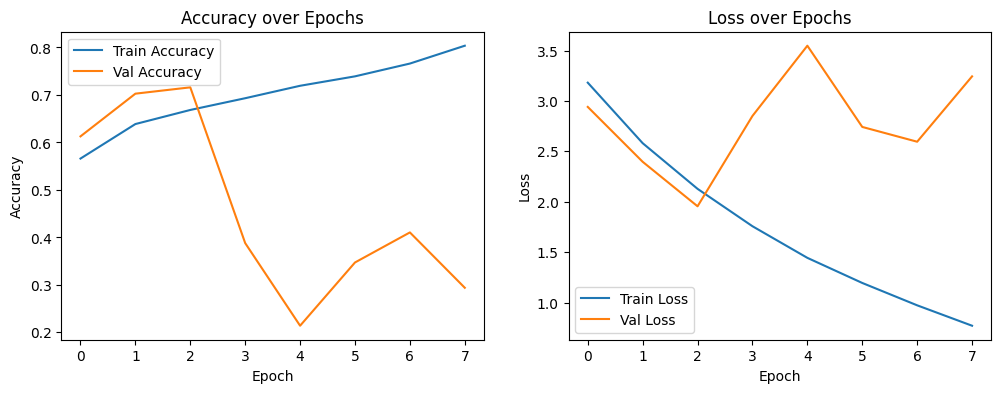

In [43]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [44]:
from sklearn.metrics import classification_report, fbeta_score

# Predict on test data
y_pred_probs = model.predict(X_test_final)

y_pred = np.argmax(y_pred_probs, axis=1)

38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step


In [45]:
beta = 5
# Classification report
print(classification_report(y_test_final, y_pred, target_names=['Negative', 'Neutral', 'Positive']))
print(f'F{beta} Score: ')
print(fbeta_score(y_test_final, y_pred, average=None, beta=beta))


              precision    recall  f1-score   support

    Negative       0.18      0.65      0.28        52
     Neutral       0.33      0.23      0.27       182
    Positive       0.91      0.83      0.87       968

    accuracy                           0.73      1202
   macro avg       0.47      0.57      0.47      1202
weighted avg       0.79      0.73      0.75      1202

F5 Score: 
[0.59328859 0.2333832  0.83339313]


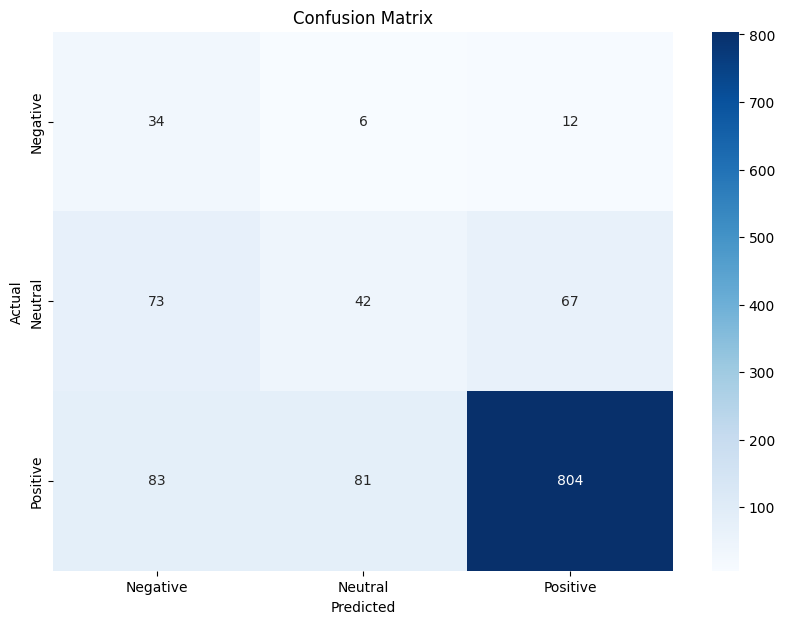

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test_final, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [47]:
from sklearn.metrics import precision_recall_fscore_support, classification_report
import numpy as np


# Set your alpha value
alpha = 0.5  # Adjust alpha as needed

# Get precision, recall, f1 for each label
precision, recall, f1, _ = precision_recall_fscore_support(y_pred, y_test, labels=[0, 1, 2])

# Manually compute F_alpha
f_alpha = (1 + alpha**2) * (precision * recall) / (alpha**2 * precision + recall)

# Handle division by zero if precision + recall == 0
f_alpha = np.nan_to_num(f_alpha)

# Print precision, recall, f1, and F_alpha
for i, label in enumerate([0, 1, 2]):
    print(f"Label {label}:")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall:    {recall[i]:.2f}")
    print(f"  F1 Score:  {f1[i]:.2f}")
    print(f"  F{alpha} Score: {f_alpha[i]:.2f}")
    print()

# Optionally use the built-in classification report for comparison (with F1 score)
print("\nClassification Report (F1 score):")
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))


ValueError: Found input variables with inconsistent numbers of samples: [1202, 2403]

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve


 # Predict probabilities
y_pred_probs = model.predict(X_test_padded)

# Compute ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')
print(f'ROC-AUC Score: {roc_auc:.2f}')

# Compute ROC curve
fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_probs[:, i], pos_label=i)  
    roc_auc[i] = roc_auc_score(y_test == i, y_pred_probs[:, i])

# Plot ROC curve
plt.figure(figsize=(10, 7))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [583]:
import matplotlib.pyplot as plt

# Extract metrics from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# If you're tracking accuracy
train_acc = history.history.get('accuracy') or history.history.get('acc')
val_acc = history.history.get('val_accuracy') or history.history.get('val_acc')

# Compute the generalization gap
gen_gap_loss = [tr - vl for tr, vl in zip(train_loss, val_loss)]
gen_gap_acc = [tr - vl for tr, vl in zip(train_acc, val_acc)] if train_acc and val_acc else None

# Define the number of epochs
epochs = range(1, len(train_loss) + 1)


In [ ]:
# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Generalization Gap for Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, gen_gap_loss, 'go-', label='Generalization Gap (Loss)')
plt.title('Generalization Gap over Epochs (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss Difference')
plt.legend()

plt.tight_layout()
plt.show()

# Check if accuracy metrics are available
if train_acc and val_acc:
    # Plot Training and Validation Accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Generalization Gap for Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, gen_gap_acc, 'go-', label='Generalization Gap (Accuracy)')
    plt.title('Generalization Gap over Epochs (Accuracy)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy Difference')
    plt.legend()

    plt.tight_layout()
    plt.show()
